# Bayesian Neural Networks with `numpyro`

Deep Neural Networks are non-linear function approximators and the state of the art in pattern recognition for unstructured data (audio, images, text, video)

But they do have limitations

- Very deep models require lots of data to train
- Selecting an architecture requires a lot of experimentation
- They can be [easily ](https://arxiv.org/abs/1412.1897) [fooled](https://openai.com/blog/adversarial-example-research/)
- They are poor at representing uncertainty 

:::{note}

We can address some of these limitations by going Bayesian

:::

A Bayesian neural network (BNN) places a prior distribution on its parameters. Training the BNN is equivalent to learning the posterior distribution of the parameters given the data. 


:::{important}

The **uncertainty on the data and the parameters** can be propagated to estimate the **uncertainty on our predictions**

:::

Aleatoric uncertainty
: Uncertainty on the data, generally associated to the noise

Epistemic uncertainty
: Uncertainty associated to the model, either its structure or parameters


Having uncertainty-aware neural networks is speccially useful to

- Choose when to use a more simple/complex model (complexity-control)
- Make critical decisions, e.g. [autonomous cars](https://en.wikipedia.org/wiki/Tesla_Autopilot#Non-fatal_crashes), cancer diagnosis


**A bit of history**

A brief timeline of bayesian neural newtworks:

- 1980's: Bayes theorem is applied to Neural Networks (John Hopfield and Naftali Tishby)
- 1990's: Monte-Carlo and VI for bayesian neural networks was studied extensively by [David Mackay](http://www.inference.org.uk/mackay/BayesNets.html) and [Radford Neal](https://www.cs.toronto.edu/~radford/res-neural.html) (Also Bishop, Barber, Hinton, Gharamani and many others). Neal shows that Gaussian process are bayesian neural networks with infinite neurons
- 2011: [Alex Graves' VI for neural networks](https://papers.nips.cc/paper/4329-practical-variational-inference-for-neural-networks). Explosion of practical deep bayesian networks 
    - [Charles Blundell's Bayes by backprop](https://arxiv.org/abs/1505.05424)
    - [Yarin Gal's many work](http://mlg.eng.cam.ac.uk/yarin/thesis/thesis.pdf)
    - Durk Kingma, Danilo Jimenez Rezende, Shakir Mohamed, José Miguel Hernandez-Lobato
- [Hot topic now a days](http://bayesiandeeplearning.org/)

History in video by [Zoubin Gharamani](http://mlg.eng.cam.ac.uk/zoubin/) at [NIPS 2016](https://www.youtube.com/watch?v=FD8l2vPU5FY) and [interesting panel discussion](https://www.youtube.com/watch?v=HumFmLu3CJ8) on the same conference

## A bayesian neural model for regression

As an example let's consider an architecture for univariate regression based on fully connected layers 

$$
\begin{split}
f_\theta(x) &=   \hat b + \sum_{j=1}^{10} \hat w_{j} h_j   \\
&=  \hat b + \sum_{j=1}^{10} \hat w_{j} \text{tanh} \left( b_j + w_{j} x  \right) 
\end{split}
$$

where $\theta = (b, w, \hat b, \hat w)$ are the parameters of the neural network


This is implemented as a Python `dataclass` with `flax` as follows

In [1]:
from typing import Sequence, Callable
from dataclasses import field
import flax.linen as nn

class MultiLayerPerceptron(nn.Module):
    hidden_neurons: Sequence[int] = field(default_factory=lambda: [10])
    output_neurons: int = 1
    activation: Callable = nn.tanh
    
    @nn.compact
    def __call__(self, x):
        for neurons in self.hidden_neurons:
            x = self.activation(nn.Dense(neurons)(x)) 
        return nn.Dense(self.output_neurons)(x)

The first step to make this model bayesian is to choose **a prior for the parameters** of the network

A very typical, albeit not the best, prior is the diagonal normal:

$$
p(\theta) = \mathcal{N}(\theta | 0, \Sigma_\theta)
$$

where $\Sigma_\theta$ is generally a diagonal covariance (independent prior)

:::{note}

We will discuss more about priors for neural network parameters in the future

:::

The likelihood on the other hand is chosen based on the task, the typical choices are

- Gaussian for regression problems
- Bernoulli for binary classification problems
- Categorical for multi-class classification problems



This bayesian model can be implemented easily with `numpyro`. In particular we can place a prior on the parameters of a neural network implemented with flax using the [`random_flax_module`](https://num.pyro.ai/en/stable/primitives.html?highlight=flax#random-flax-module) primitive

This primitive expects

- A name (string)
- An object that inherits from `nn.Module`
- A distribution for the prior
- A tuple with the size of the expected input


In [2]:
import numpyro
import numpyro.distributions as dists
from numpyro.contrib.module import random_flax_module

numpyro.set_platform("cpu") 
numpyro.set_host_device_count(2) 

def model(x, y=None, n_hidden=[10], prior_std=1., activation=nn.tanh):
    batch_size, data_dim = x.shape
    net = MultiLayerPerceptron(n_hidden, activation=activation)
    bayesian_net = random_flax_module("net", net,
                                      prior = dists.Normal(0, prior_std),
                                      input_shape=(batch_size, data_dim))
    
    s = numpyro.sample('s', fn=dists.HalfCauchy(scale=0.5))
    with numpyro.plate('data', size=batch_size):
        f = numpyro.deterministic('f', value=bayesian_net(x)[:, 0])
        numpyro.sample('y', fn=dists.Normal(f, s), obs=y)
    return f

where additionally, the standard deviation of the likelihood that represents the noise in the data, is modeled as a Half Cauchy distribution

The final step is to obtain the posterior of the model

$$
p(\theta | \mathcal{D}) = \frac{p(\mathcal{D}|\theta) p(\theta)}{p(\mathcal{D})} = \frac{1}{{p(\mathcal{D})}} \prod_n \mathcal{N}(y^{(n)} | f(x^{(n)}), \sigma^2) \mathcal{N}(\theta | 0, \Sigma_\theta)
$$

:::{note}

Even though the likelihood and prior are normal **the posterior in this case is not normal** because of the nested nonlinearities in the neural network architecture, hence we resort to MCMC or SVI

:::

In the following examples we will use the same synthetic data from the linear regression lecture:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
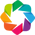

:Points   [x,y]

In [3]:
import jax.numpy as jnp
import jax.random as random
import holoviews as hv
hv.extension('bokeh')

key = random.PRNGKey(0)
x = jnp.sort(dists.Uniform(-1, 1).sample(key, sample_shape=(40, 1)))
f = lambda x : x*jnp.sin(5*x)
sub_key, key = random.split(key)
y = f(x) + dists.Normal(0., 0.1).rsample(sub_key, sample_shape=(x.shape))
x_test = jnp.linspace(-1.5, 1.5, num=200)[:, jnp.newaxis]

data_plot = hv.Points((x.ravel(), y.ravel()), label='Train data').opts(width=500, size=5, color='black')
data_plot

## "Training" the model using MCMC

Samples from the posterior of the neural network can be obtained using MCMC. Then these samples can be used to compute the predictive posterior of the network over new data

$$
p(\mathbf{y}|\mathbf{x}, \mathcal{D}) = \int p(\mathbf{y}|\mathbf{x}, \theta) p(\theta| \mathcal{D}) \,d\theta
$$

In what follows we run two MCMC chains using the `NUTS` sampler, a suitable choice given that the neural network is differentiable

In [4]:
from numpyro.infer import MCMC, NUTS
from functools import partial

partial_model = partial(model, n_hidden=[10], prior_std=1., activation=nn.tanh)

sampler = MCMC(sampler=NUTS(partial_model, adapt_step_size=True), 
               num_chains=2, num_samples=2000, num_warmup=200, 
               jit_model_args=True)

sampler.run(random.PRNGKey(1234), x, y[:, 0])

  0%|          | 0/2200 [00:00<?, ?it/s]

  0%|          | 0/2200 [00:00<?, ?it/s]

/home/phuijse/.conda/envs/info320/lib/python3.10/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


As a preliminary convergence check the $\hat r$ and effective number of samples are inspected:

In [5]:
sampler.print_summary(0.9)


                             mean       std    median      5.0%     95.0%     n_eff     r_hat
    net/Dense_0.bias[0]     -0.01      1.13     -0.02     -1.92      1.80    267.37      1.01
    net/Dense_0.bias[1]     -0.08      1.13     -0.10     -1.98      1.76    371.68      1.01
    net/Dense_0.bias[2]     -0.11      1.10     -0.11     -1.98      1.60    415.80      1.00
    net/Dense_0.bias[3]      0.01      1.13     -0.00     -1.82      1.92    455.13      1.01
    net/Dense_0.bias[4]     -0.06      1.06     -0.06     -1.75      1.73    323.52      1.02
    net/Dense_0.bias[5]      0.10      1.11      0.13     -1.68      1.98    573.15      1.00
    net/Dense_0.bias[6]      0.02      1.08      0.02     -1.80      1.78    623.22      1.00
    net/Dense_0.bias[7]      0.13      1.16      0.09     -1.62      2.14    172.98      1.01
    net/Dense_0.bias[8]      0.01      1.15     -0.03     -1.79      2.02    270.71      1.02
    net/Dense_0.bias[9]      0.19      1.09      0.37     -

Let's inspect some of the traces:

In [6]:
samples = sampler.get_samples(group_by_chain=False)
samples.keys()

def plot_trace_and_distribution(trace: jnp.array, name: str):
    trace_plot = hv.Curve((trace), 'Step', name).opts(width=400, height=200)
    dist_plot = hv.Distribution((trace), name).opts(width=200, height=200).opts(bandwidth=0.1)
    return trace_plot + dist_plot

print(samples['net/Dense_1.bias'].shape)
plot_trace_and_distribution(samples['net/Dense_1.bias'][:, 0], 'Output bias')

(4000, 1)


:Layout
   .Curve.I        :Curve   [Step]   (Output bias)
   .Distribution.I :Distribution   [Output bias]   (Density)

In [7]:
print(samples['net/Dense_1.kernel'].shape)
plot_trace_and_distribution(samples['net/Dense_1.kernel'][:, 0, 0], 'First output weight')

(4000, 10, 1)


:Layout
   .Curve.I        :Curve   [Step]   (First output weight)
   .Distribution.I :Distribution   [First output weight]   (Density)

In [8]:
print(samples['net/Dense_0.kernel'].shape)
plot_trace_and_distribution(samples['net/Dense_0.kernel'][:, 0, 0], 'First hidden weight')

(4000, 1, 10)


:Layout
   .Curve.I        :Curve   [Step]   (First hidden weight)
   .Distribution.I :Distribution   [First hidden weight]   (Density)

In [9]:
print(samples['net/Dense_0.bias'].shape)
plot_trace_and_distribution(samples['net/Dense_0.bias'][:, 0], 'First hidden bias')

(4000, 10)


:Layout
   .Curve.I        :Curve   [Step]   (First hidden bias)
   .Distribution.I :Distribution   [First hidden bias]   (Density)

In [10]:
print(samples['s'].shape)
plot_trace_and_distribution(samples['s'], 'Likelihood std')

(4000,)


:Layout
   .Curve.I        :Curve   [Step]   (Likelihood std)
   .Distribution.I :Distribution   [Likelihood std]   (Density)

And the predictive posterior over the test data:

In [11]:
predictive = numpyro.infer.Predictive(partial_model, 
                                      posterior_samples=sampler.get_samples(), 
                                      return_sites=['f'])
posterior_samples = predictive(random.PRNGKey(1), x_test)

def plot_predictive(posterior_samples):
    low, mid, upper = jnp.quantile(posterior_samples['f'], jnp.array([0.025, 0.5, 0.975]), axis=0)
    median = hv.Curve((x_test, mid), label='Median').opts(width=500, color='#30a2da')
    uncertainty = hv.Area((x_test, low, upper), vdims=['y', 'y2'], label='95% CI').opts(color='#30a2da', alpha=0.3)
    return hv.Overlay([median, uncertainty, data_plot]).opts(legend_position='bottom_right')

plot_predictive(posterior_samples)

:Overlay
   .Curve.Median         :Curve   [x]   (y)
   .Area.A_95_percent_CI :Area   [x]   (y,y2)
   .Points.Train_data    :Points   [x,y]

### The effects of the hyperparameters

In [12]:
def predictive_mcmc(n_hidden, prior_std, activation):
    partial_model = partial(model, n_hidden=n_hidden, 
                            prior_std=prior_std, 
                            activation=activation)

    sampler = MCMC(sampler=NUTS(partial_model, adapt_step_size=True), 
                   num_chains=2, num_samples=2000, num_warmup=200, 
                   jit_model_args=True)

    sampler.run(random.PRNGKey(1234), x, y[:, 0])

    predictive = numpyro.infer.Predictive(partial_model, 
                                          posterior_samples=sampler.get_samples(), 
                                          return_sites=['f'])
    posterior_samples = predictive(random.PRNGKey(1), x_test)
    return plot_predictive(posterior_samples)

Standard deviation of the prior too small: Extreme regularization

In [13]:
predictive_mcmc([10], 0.1, nn.tanh)

  0%|          | 0/2200 [00:00<?, ?it/s]

  0%|          | 0/2200 [00:00<?, ?it/s]

/home/phuijse/.conda/envs/info320/lib/python3.10/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


:Overlay
   .Curve.Median         :Curve   [x]   (y)
   .Area.A_95_percent_CI :Area   [x]   (y,y2)
   .Points.Train_data    :Points   [x,y]

Standard deviation of the prior too large: Extreme flexibility

In [14]:
predictive_mcmc([10], 10., nn.tanh)

  0%|          | 0/2200 [00:00<?, ?it/s]

  0%|          | 0/2200 [00:00<?, ?it/s]

/home/phuijse/.conda/envs/info320/lib/python3.10/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


:Overlay
   .Curve.Median         :Curve   [x]   (y)
   .Area.A_95_percent_CI :Area   [x]   (y,y2)
   .Points.Train_data    :Points   [x,y]

Too few hidden units: Not enough flexibility

In [15]:
predictive_mcmc([2], 1., nn.tanh)

  0%|          | 0/2200 [00:00<?, ?it/s]

  0%|          | 0/2200 [00:00<?, ?it/s]

/home/phuijse/.conda/envs/info320/lib/python3.10/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


:Overlay
   .Curve.Median         :Curve   [x]   (y)
   .Area.A_95_percent_CI :Area   [x]   (y,y2)
   .Points.Train_data    :Points   [x,y]

Too many hidden units: More flexibility but no overfitting thanks to the regularization of the prior

In [16]:
predictive_mcmc([100], 1., nn.tanh)

  0%|          | 0/2200 [00:00<?, ?it/s]

  0%|          | 0/2200 [00:00<?, ?it/s]

/home/phuijse/.conda/envs/info320/lib/python3.10/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


:Overlay
   .Curve.Median         :Curve   [x]   (y)
   .Area.A_95_percent_CI :Area   [x]   (y,y2)
   .Points.Train_data    :Points   [x,y]

Different activation function: ReLU

In [17]:
predictive_mcmc([10], 1., nn.relu)

  0%|          | 0/2200 [00:00<?, ?it/s]

  0%|          | 0/2200 [00:00<?, ?it/s]

/home/phuijse/.conda/envs/info320/lib/python3.10/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


:Overlay
   .Curve.Median         :Curve   [x]   (y)
   .Area.A_95_percent_CI :Area   [x]   (y,y2)
   .Points.Train_data    :Points   [x,y]

## Training the model using SVI

In SVI we propose an approximate (simple) posterior $q_\nu(\theta)$ with which we maximize the evidence lower bound (ELBO)

$$
\mathcal{L}(\nu) = \mathbb{E}_{q_\nu(\theta)}[ \log p(\mathcal{D}|\theta)] - \text{KL}[q_\nu(\theta)|p(\theta)]
$$


In [19]:
import jax
import optax
from tqdm.notebook import tqdm
from numpyro.infer.autoguide import AutoNormal

clipped_adam = optax.chain(optax.clip_by_global_norm(10.0),  
                           optax.scale_by_adam(),
                           optax.scale(-1e-2))

def train_svi(model, guide, key, nepochs=10000):
    svi = numpyro.infer.SVI(model, 
                            guide, 
                            clipped_adam, 
                            loss=numpyro.infer.TraceMeanField_ELBO(num_particles=10))
    state = svi.init(key, x, y[:, 0])
    
    loss_evolution = []
    jit_update = jax.jit(svi.update)
    for epoch in tqdm(range(nepochs)):
        state, loss = jit_update(state, x, y[:, 0])
        loss_evolution.append(loss.item())
    
    return svi, state, loss_evolution
 
partial_model = partial(model, n_hidden=[10], prior_std=10., activation=nn.tanh)
guide = AutoNormal(partial_model, init_scale=1e-3)

svi, state, loss_evolution = train_svi(partial_model, guide, random.PRNGKey(1234))  
hv.Curve(loss_evolution, 'Epoch', 'Loss').opts(width=500, logy=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

:Curve   [Epoch]   (Loss)

:::{tip}

Use a small initial variance for the parameters of the guide (`init_scale` argument). This avoids numerical instabilities when training begins

:::

:::{tip}

Another way to decrease variance is to increace `num_particles` in the ELBO cost function (number of monte carlo samples). Note that this trades lower variance of the gradients by computational cost.

:::

Then we use $q_\nu(\theta)$ as our replacement for $p(\theta|\mathcal{D})$ to calculate the **posterior predictive distribution**

In [20]:
predictive = numpyro.infer.Predictive(partial_model, 
                                      guide=svi.guide, 
                                      params=svi.get_params(state), 
                                      num_samples=1000,
                                      return_sites=['f'])

posterior_samples = predictive(random.PRNGKey(1), x_test)
plot_predictive(posterior_samples)

:Overlay
   .Curve.Median         :Curve   [x]   (y)
   .Area.A_95_percent_CI :Area   [x]   (y,y2)
   .Points.Train_data    :Points   [x,y]

## A Bayesian neural network for multi-class classification

Let's create a synthetic 2D dataset with 3 classes

In [21]:
import numpy as np

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) 
y = np.zeros(N*K, dtype='int')

for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0, 0.5, N) # radius
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
    
hv.Scatter((X[:, 0], X[:, 1], y), 
           'x0', vdims=['x1', 'y']).opts(color='y', width=400, cmap='tab10')

:Scatter   [x0]   (x1,y)

The following is Bayesian model for multi-class classification using the same neural network architecture as before

A `CategoricalLogits` distributions is used for the likelihood

In [22]:
def model_classification(x, y=None, n_hidden=[10], prior_std=1., activation=nn.tanh):
    batch_size, data_dim = x.shape
    net = MultiLayerPerceptron(n_hidden, output_neurons=3, activation=activation)
    bayesian_net = random_flax_module("net", net, 
                                      prior=dists.Normal(0, prior_std),
                                      input_shape=(batch_size, data_dim))
    
    with numpyro.plate('data', size=batch_size):
        logitp = numpyro.deterministic('p', value=bayesian_net(x))
        numpyro.sample('y', fn=dists.CategoricalLogits(logitp), obs=y)

Again we use an automatic diagonal normal guide (no covariance)

In [23]:
partial_model = partial(model_classification, n_hidden=[100], prior_std=10., activation=nn.relu)
guide = AutoNormal(partial_model, init_scale=1e-2)

def train_svi(model, guide, key, nepochs=10000):
    svi = numpyro.infer.SVI(model, 
                            guide, 
                            clipped_adam, 
                            loss=numpyro.infer.TraceMeanField_ELBO(num_particles=10))
    state = svi.init(key, X, y)
    
    loss_evolution = []
    jit_update = jax.jit(svi.update)
    for epoch in tqdm(range(nepochs)):
        state, loss = jit_update(state, X, y)
        loss_evolution.append(loss.item())
    
    return svi, state, loss_evolution

svi, state, loss_evolution = train_svi(partial_model, guide, random.PRNGKey(1234))  
hv.Curve(loss_evolution, 'Epoch', 'Loss').opts(width=500)

  0%|          | 0/10000 [00:00<?, ?it/s]

:Curve   [Epoch]   (Loss)

And use the fitted guide to obtain samples from the predictive distribution

In [24]:
predictive = numpyro.infer.Predictive(partial_model, 
                                      guide=svi.guide, 
                                      params=svi.get_params(state), 
                                      num_samples=100,
                                      return_sites=['y'])

xx1, xx2 = jnp.meshgrid(jnp.arange(-0.5, 0.5, 0.01), jnp.arange(-0.5, 0.5, 0.01))
posterior_samples = predictive(random.PRNGKey(1), jnp.stack((xx1.ravel(), xx2.ravel())).T)

The first three samples from the predictive distribution:

In [26]:
def plot_predictive(prediction, cmap='tab10'):
    pred = hv.Image(np.array(prediction.reshape(xx1.shape)).T).opts(width=300, cmap=cmap) 
    data = hv.Scatter((X[:, 0], X[:, 1])).opts(color='k')
    return pred * data
                      
hv.Layout([plot_predictive(posterior_samples['y'][k, :]) for k in range(3)]).cols(3)

:Layout
   .Overlay.I   :Overlay
      .Image.I   :Image   [x,y]   (z)
      .Scatter.I :Scatter   [x]   (y)
   .Overlay.II  :Overlay
      .Image.I   :Image   [x,y]   (z)
      .Scatter.I :Scatter   [x]   (y)
   .Overlay.III :Overlay
      .Image.I   :Image   [x,y]   (z)
      .Scatter.I :Scatter   [x]   (y)

We can summarize the categorical predictive distribution. The plot on the left shows the mode of the distribution (most repeated class) and the plot on the right shows the entropy of the distribution

In [27]:
freqs = jnp.stack([np.sum(posterior_samples['y']==k, axis=0) for k in range(3)])/posterior_samples['y'].shape[0]
mode = jnp.argmax(freqs, axis=0)
entropy = -(freqs*jnp.log(freqs+1e-10)).sum(axis=0)
plot_predictive(mode) + plot_predictive(entropy, cmap='Blues')

:Layout
   .Overlay.I  :Overlay
      .Image.I   :Image   [x,y]   (z)
      .Scatter.I :Scatter   [x]   (y)
   .Overlay.II :Overlay
      .Image.I   :Image   [x,y]   (z)
      .Scatter.I :Scatter   [x]   (y)

:::{note}
            
The higher then entropy the more different the output of the predictive samples (higher uncertainty)

:::

For comparison let's see the result of an equivalent deterministic neural network

In [30]:
from flax.training import train_state

net = MultiLayerPerceptron([100], output_neurons=3, activation=nn.relu)
nepochs = 10000
dummy_batch = jnp.ones(shape=X.shape)
state = train_state.TrainState.create(apply_fn=net.apply, 
                                      params=net.init(random.PRNGKey(12345), dummy_batch)['params'],
                                      tx=clipped_adam)
@jax.jit
def train_step(state, batch, label):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch)
        one_hot = jax.nn.one_hot(label, num_classes=logits.shape[1])
        return optax.softmax_cross_entropy(logits, one_hot).mean()
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    return loss, state.apply_gradients(grads=grads)

loss = []
for epoch in tqdm(range(nepochs)):
    loss_value, state = train_step(state, X, y)
    loss.append(loss_value.item())
    
hv.Curve((range(nepochs), loss), 'Epoch', 'Loss').opts(width=500, height=200)

  0%|          | 0/10000 [00:00<?, ?it/s]

:Curve   [Epoch]   (Loss)

If we treat the output of the network as probabilities we can also compute its entropy

Is it the same as before?

In [31]:
freqs = nn.softmax(net.apply({'params': state.params}, jnp.stack((xx1.ravel(), xx2.ravel())).T))
mode = jnp.argmax(freqs, axis=1)
entropy = -(freqs*jnp.log(freqs+1e-10)).sum(axis=1)
plot_predictive(mode) + plot_predictive(entropy, cmap='Blues')

:Layout
   .Overlay.I  :Overlay
      .Image.I   :Image   [x,y]   (z)
      .Scatter.I :Scatter   [x]   (y)
   .Overlay.II :Overlay
      .Image.I   :Image   [x,y]   (z)
      .Scatter.I :Scatter   [x]   (y)

This is related to phenomenon of **uncertainty miscalibration in neural networks**, i.e. the uncertainty of the predictions tends to be very low even when far from the data

> "after (almost) all training samples are correctly classified, crossentropy (neg log likelihood) can be further minimized by increasing the confidence of the predictions", *i.e.* reducing the entropy of softmax output

The uncertainty obtained from model averaging (bayesian) and the one derived from the softmax output are not equivalent and should not be confused

Further reading and references on this topic:

- [On Calibration of Modern Neural Networks](https://arxiv.org/pdf/1706.04599.pdf)
- [Being Bayesian, Even Just a Bit,Fixes Overconfidence in ReLU Networks](https://arxiv.org/pdf/2002.10118v1.pdf)
- [Evidential Deep Learning to Quantify Classification Uncertainty](https://arxiv.org/pdf/1806.01768.pdf)